# Reports
1. Inputs: data raw from kaggle
2. Outputs: analytics and data with feature engineering
3. ...

# 1.0 Imports

###### 1.1 Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pylab as pl

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier, plot_tree

from scipy.stats import shapiro, kstest

from scipy.stats import ttest_ind

import pickle

import time
import warnings

# Tempo de processamento
time_agora = time.time()

###### 1.2 Helper Functions

In [2]:
def comparar_features(series1, series2, confiança, qtd_amostras):
    print('Series 1')
    print(f'Média = {round(series1.mean(), 2)}')
    print(f'Desvio padrão = {round(series1.std(), 2)}')
    print()
    print('Series 2')
    print(f'Média = {round(series2.mean(), 2)}')
    print(f'Desvio padrão = {round(series2.std(), 2)}')
    aleatório1 = np.random.choice(series1.dropna(), qtd_amostras)
    aleatório2 = np.random.choice(series2.dropna(), qtd_amostras)
    stat, p = ttest_ind(aleatório1, aleatório2)
    print(f'statistic = {round(stat, 2)}, p = {round(p, 2)}')
  
    if p < confiança:
        print(f'\nCom um p-valor igual à {round(p, 2)}, as series são estatísticamente DIFERENTES com um grau de confiança de {round(100-confiança*100)}%')
    if p > confiança:
        print(f'\nCom um p-valor igual à {round(p, 2)}, as series são estatísticamente IGUAIS com um grau de confiança de {round(100-confiança*100)}%')


# Função buscar outlier pelo método do 6 Sigma
def buscar_outlier(df, series):
    média = df[series].mean()
    desvio_padrão = df[series].std()
    lis = média - (desvio_padrão * 3)
    lss = média + (desvio_padrão * 3)
    lista_outliers = df[(df[series] < lis) | (df[series] > lss)].index
    return lista_outliers, lis, lss

# Análise descritiva de primeira ordem
def analise_descritiva(x):
    print(f'A média da Series é: {round(np.mean(x), 2)}')
    print(f'O valor máximo da Series é: {np.max(x)}')
    print(f'O valor mínimo da Series é: {np.min(x)}')
    print(f'O range é de: {np.max(x)-np.min(x)}')
    print(f'O desvio padrão da Series é: {round(np.std(x), 2)}')
    print(f'A curtose da Series é: {round(x.kurtosis(), 2)}')
    print(f'A skew da Series é: {round(x.skew(), 2)}')
    
# Teste de Shapiro
def teste_shapiro(df, series):
    random_index = np.random.choice(df.index, 500)
    temp = df.loc[random_index]
    shapiro_test = shapiro(temp[series].dropna())
    if shapiro_test.pvalue > 0.05:
        print(f'Com um p-valor = {round(shapiro_test.pvalue, 3)}, e alpha de 5%, falha em rejeitar a hipótese nula.')
    else:
        print(f'Com um p-valor = {round(shapiro_test.pvalue, 3)}, e alpha de 5%, rejeita a hipótese nula.')

###### 1.3 Loading Dataset

In [3]:
train = pd.read_csv(r'D:\\My Drive\\Pessoal\\Projetos\\insurance_sales_predict\\insurance_sales_predict\\train.csv')
test = pd.read_csv(r'D:\\My Drive\\Pessoal\\Projetos\\insurance_sales_predict\\insurance_sales_predict\\test.csv')

###### 1.4 Concating Train and Test into a Matrix Dataset

In [4]:
df_raw = pd.concat([train, test])
df = df_raw.copy()

###### 1.5 Creating Submission Table

In [5]:
submission = pd.DataFrame()
submission['id'] = test['id']

# 2.0 Data Description

## 2.1 General Analysis

##### 2.1.0 Main insights:

###### Response:
1. Desbalanceada com 12% de eventos positivos

###### Vehicle_Age:
1. Mais da metade dos clientes possuem carros com menos de 1 ano

###### Region_Code:
1. 53 regiões
2. 28% dos clientes está contido na região 28. 
3. 50% dos dados estão contidos nas 5 regiões mais numerosas

###### Policy_Sales_Channel:
1. Há 157 Policy_Sales_Channel e aproximadamente um terço das amostras está contido no canal 152

###### Vintage:
1. Feature categórica, há 290 categorias em Vintage

###### Age:
1. Range de idade de 25 até 85 anos, aparentemente sem erros de input

##### 2.1.1 Data dimensions

In [6]:
print(f'Number of rows: {train.shape[0]}')
print(f'Number of columns: {train.shape[1]}')

Number of rows: 381109
Number of columns: 12


##### 2.1.2 Data types

In [7]:
train.dtypes

id                        int64
Gender                   object
Age                       int64
Driving_License           int64
Region_Code             float64
Previously_Insured        int64
Vehicle_Age              object
Vehicle_Damage           object
Annual_Premium          float64
Policy_Sales_Channel    float64
Vintage                   int64
Response                  int64
dtype: object

##### 2.1.3 Look table

In [8]:
train.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


Gender, Vehicle_Age, Vehicle_Damage precisam ser transformados para que possam haver estudos de correlação

##### 2.1.4 Changing Interesting datatypes

In [9]:
le_gender = LabelEncoder().fit(df['Gender'])
df['Gender_'] = le_gender.transform(df['Gender'])

le_vehicle_damage = LabelEncoder().fit(df['Vehicle_Damage'])
df['Vehicle_Damage_'] = le_vehicle_damage.transform(df['Vehicle_Damage'])

le_vehicle_age = LabelEncoder().fit(df['Vehicle_Age'])
df['Vehicle_Age_'] = le_vehicle_age.transform(df['Vehicle_Age'])

##### 2.1.5 Segregating feature types

In [10]:
features_id = ['id']
features_string = ['Gender', 'Vehicle_Damage', 'Vehicle_Age']
features_categóricas = ['Gender_', 'Vehicle_Damage_', 'Vehicle_Age_', 'Driving_License', 'Region_Code', 'Previously_Insured', 'Policy_Sales_Channel', 'Vintage']
features_numéricas = ['Age', 'Annual_Premium']
target = ['Response']

##### 2.1.6 Check NaN values

In [11]:
df.isna().sum()

id                           0
Gender                       0
Age                          0
Driving_License              0
Region_Code                  0
Previously_Insured           0
Vehicle_Age                  0
Vehicle_Damage               0
Annual_Premium               0
Policy_Sales_Channel         0
Vintage                      0
Response                127037
Gender_                      0
Vehicle_Damage_              0
Vehicle_Age_                 0
dtype: int64

Sem valores nulos

## 2.2 Descriptive Statistics

### 2.2.1 Target

In [12]:
print(f'A porcentagem de interessados no produto é: {round(df["Response"].mean(), 2) * 100} %')

A porcentagem de interessados no produto é: 12.0 %


Desbalanceada

### 2.2.2 Numerical Features

In [13]:
df[features_numéricas].describe()

,Age,Annual_Premium
count,508146.000000,508146.000000
mean,38.808413,30554.453041
std,15.500179,17146.574625
min,20.000000,2630.000000
25%,25.000000,24381.000000
50%,36.000000,31661.000000
75%,49.000000,39403.750000
max,85.000000,540165.000000


Range de idade entre 20 e 85 anos, sem indícios de erros de inputs, Annual_Premium com possíveis outliers

###### Age

In [14]:
analise_descritiva(df['Age'])

A média da Series é: 38.81
O valor máximo da Series é: 85
O valor mínimo da Series é: 20
O range é de: 65
O desvio padrão da Series é: 15.5
A curtose da Series é: -0.56
A skew da Series é: 0.67


###### Annual_Premium

In [15]:
analise_descritiva(df['Annual_Premium'])

A média da Series é: 30554.45
O valor máximo da Series é: 540165.0
O valor mínimo da Series é: 2630.0
O range é de: 537535.0
O desvio padrão da Series é: 17146.56
A curtose da Series é: 30.05
A skew da Series é: 1.6


### 2.2.3 Categorical Features

In [16]:
df[features_categóricas].astype('category').describe()

,Gender_,Vehicle_Damage_,Vehicle_Age_,Driving_License,Region_Code,Previously_Insured,Policy_Sales_Channel,Vintage
count,508146,508146,508146,508146,508146.0,508146,508146.0,508146
unique,2,2,3,2,53.0,2,157.0,290
top,1,1,0,1,28.0,0,152.0,256
freq,274325,256248,267015,507097,141937.0,275076,179523.0,1877


In [17]:
le_gender.inverse_transform([0])

array(['Female'], dtype=object)

In [18]:
le_vehicle_damage.inverse_transform([1])

array(['Yes'], dtype=object)

In [19]:
le_vehicle_age.inverse_transform([1])

array(['< 1 Year'], dtype=object)

Sexo relativamente balanceado com a maioria de mulheres, maior parte dos clientes possuem veículos com menos de 1 ano, maior parte dos clientes já teve danos em seu veículo, habilitação para dirigir balanceado, há 53 regiões diferentes e por volta de 30% dos clientes estão contidos na região 28, um pouco mais que 50% dos clientes não possuem seguro veicular, há 157 canais de vendas, e por volta de 35% dos clientes estão contidos no canal 152.

# 3.0 Feature Engineering

###### 3.1 Policy_Sales_Channel Response Mean

In [20]:
group = train[['Policy_Sales_Channel', 'Response']].groupby('Policy_Sales_Channel').agg({'Response':'mean'})
map_policy_sales_channel_response_mean = group.to_dict()['Response']
df['Policy_Sales_Channel_Response_Mean'] = df['Policy_Sales_Channel'].map(map_policy_sales_channel_response_mean)

In [21]:
df.corr()['Policy_Sales_Channel_Response_Mean'].sort_values(ascending=False)[1:]

Age                     0.636832
Vehicle_Damage_         0.435397
Response                0.263429
Gender_                 0.169888
Region_Code             0.026936
id                     -0.000003
Annual_Premium         -0.000101
Vintage                -0.001333
Driving_License        -0.032776
Previously_Insured     -0.419215
Policy_Sales_Channel   -0.527793
Vehicle_Age_           -0.573390
Name: Policy_Sales_Channel_Response_Mean, dtype: float64

Correlações fortes com Age, correlações moderadas com Vehicle_Damage, Vehicle_Age, Previously_Insured, correlação fraca com Response

###### 3.2 Region_Code Response Mean

In [22]:
group = train[['Region_Code', 'Response']].groupby('Region_Code').agg({'Response':'mean'})
map_region_code_response_mean = group.to_dict()['Response']
df['Region_Code_Response_Mean'] = df['Region_Code'].map(map_region_code_response_mean)

In [23]:
df.corr()['Region_Code_Response_Mean'].sort_values(ascending=False)[1:]

Policy_Sales_Channel_Response_Mean    0.373014
Age                                   0.316050
Annual_Premium                        0.252035
Vehicle_Damage_                       0.195931
Response                              0.138095
Region_Code                           0.076274
Gender_                               0.044496
Vintage                               0.000319
id                                   -0.000191
Driving_License                      -0.016148
Previously_Insured                   -0.179897
Vehicle_Age_                         -0.207726
Policy_Sales_Channel                 -0.287069
Name: Region_Code_Response_Mean, dtype: float64

Correlações fracas com Age, Annual_Premium, Policy_Sales_Channel e Vehicle_Age

###### 3.3 High_Age

In [24]:
df.loc[df['Age']<30, 'High_Age'] = 0
df['High_Age'].fillna(1, inplace=True)

###### 3.4 Log_Annual_Premium

In [25]:
df['Log_Annual_Premium'] = np.log1p(df['Annual_Premium'])

###### 3.5 Annual_Premium_Variated

In [26]:
df.loc[df['Annual_Premium']==2630, 'Annual_Premium_Variated'] = 0
df['Annual_Premium_Variated'].fillna(1, inplace=True)

Feature **Annual_Premium_Variated** não contribuiu com o modelo e foi removida posteriormente

###### 3.6 High_Annual_Premium

In [27]:
temp = np.percentile(df.loc[df['Annual_Premium_Variated']==1, 'Annual_Premium'], 75)
df.loc[df['Annual_Premium']>= temp, 'High_Annual_Premium'] = 1
df['High_Annual_Premium'].fillna(0, inplace=True)

Feature **High_Annual_Premium** não contribuiu com o modelo e foi removida posteriormente

# 4.0 Business Hypothesis

##### 4.1 Clientes que já possuem seguro veicular têm menos de 5% de interesse em adquirir o produto.

##### 4.2 Clientes com mais de 30 anos de idade têm em média interesse pelo menos 100% maior no produto em relação à média de interesse dentre os clientes menos de 30 anos de idade.

1. **Hipótese Nula ou H0**: Clientes com mais de 30 anos de idade têm em média interesse pelo menos 100% maior no produto em relação à média de interesse dentre os clientes menos de 30 anos de idade.

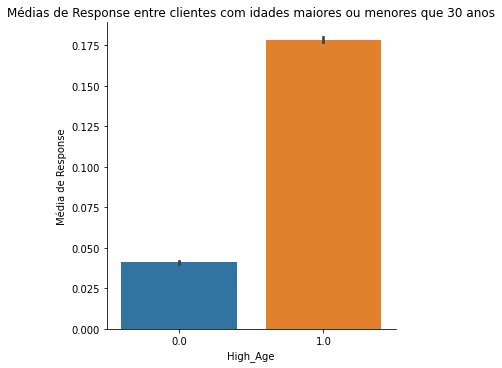

In [28]:
sns.catplot(x='High_Age', y='Response', data=df, kind='bar')
plt.ylabel('Média de Response')
plt.title('Médias de Response entre clientes com idades maiores ou menores que 30 anos');

A média de response dentre os clientes com mais de 30 anos é mais do que 100% superior em relação aos clientes com menos de 30 anos. Aceita e hipótese nula.

##### 4.3 Clientes com valores de Annual_Premium variáveis e acima do terceiro quartil (High_Annual_Premium) apresentam 50% mais interesse no produto

1. **Hipótese Nula ou H0**: Clientes com valores de Annual_Premium variáveis e acima do terceiro quartil (High_Annual_Premium) apresentam 50% mais interesse no produto

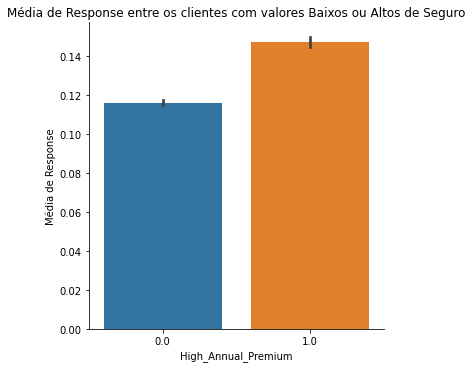

In [29]:
sns.catplot(x='High_Annual_Premium', y='Response', data=df, kind='bar')
plt.ylabel('Média de Response')
plt.title('Média de Response entre os clientes com valores Baixos ou Altos de Seguro');

A diferença entre as médias de Response foi de por volta de 20% entre os grupos, portanto, rejeita a hipótese nula.

# 5.0 Exploratory Data Analysis

## 5.1 Principais Insights:

### Espaço Amostral
1. 6 dimensões parecem explicar 90% de toda variabilidade das features
2. Annual_Premium transformada por log apresenta uma shape semelhante a uma normal
3. 4 features binárias, 2 numéricas, 1 categórica e 2 categóricas com excessivas categorias e portanto foram transformadas em numéricas.

### Features Analysis

###### Response:
1. Desbalanceada com 12% de eventos positivos
2. Correlação fraca com Vehicle_Damage e correlação fraca negativa com Previously_Insured

###### Gender:
1. Balanceada
2. Correlações muito fracas
3. Homens se interessam 30% mais no produto em relação às mulheres

###### Vehicle_Age:
1. Mais da metade dos clientes possuem carros com menos de 1 ano
2. Correlação moderada negativa com Age, fraca positiva com Policy_Sales_Channel
3. Médias de response bastante distintas

###### Vehicle_Damage:
1. Balanceada
2. Correlação muito forte negativa com Previously_Insured, fraca negativa com Policy_Sales_Channel, fraca positiva com Response e Age
3. Clientes que já tiveram danos no seu veículo tem 24% de response, enquanto clientes que não tiveram danos têm por volta de 1%

###### Driving_License:
1. Correlações muito fracas
2. 99% dos clientes são habilitados
3. Habilitados apresentam 5% de interesse no produto, não habilitados apresentam 12% de interesse no produto.

###### Previously_Insured:
1. 45% dos clientes já possuem seguro veicular
2. Clientes que já possuem seguro têm interesse quase zero pelo produto
3. Correlação muito forte negativa com Vehicle_Damage, fraca negativa com Response e Age, e fraca positiva com Policy_Sales_Channel

###### Region_Code:
1. 53 regiões
2. 28% dos clientes está contido na região 28. 50% dos dados estão contidos nas 5 regiões mais numerosas
3. A região 28 (mais importante) tem por volta de 18% de probabilidade de response, segunda melhor região, atrás apenas da região 38.
4. As regiões com probabilidade de response mais alto estão com por volta de 19%, as regiões com probabilidades mais baixas estã em por volta de 4%
5. Médias de response bastante distintas, com desvios padrões baixos

###### Policy_Sales_Channel:
1. Há 157 Policy_Sales_Channel e aproximadamente um terço das amostras está contido no canal 152
2. 5 categorias contém 84.19% do total de clientes
3. Correlação moderada negativa com Age, correlação fraca negativa com Vehicle_Damage, correlação fraca positiva com Vehicle_Age e Previously_Insured
4. Médias de response por canais de Policy_Sales_Channel bastante distintas
5. Os canais mais utilizados apresentam médias de response bastante diferentes da média global, os canal 152 é o mais utilizado e apresenta 2% de interesse no produto, o canal 155 apresenta 2%, já os canais 26, 124 e 156 apresentam por volta de 20% de interesse no produto

###### Vintage:
1. Feature categórica, há 290 categorias em Vintage

###### Age:
1. Range de idade de 25 até 85 anos, aparentemente sem erros de input
2. Apresenta uma distribuição com uma certa semelhança com uma Poison, mas com uma segunda moda em um ponto próximo aos 45 anos.
3. Sem outliers
4. A média de idade entre os que não se interessam pelo produto é de 38 anos, e dos que se interessam é de 43 anos.
5. Pessoas com mais de 30 anos apresentam um interesse relativamente maior pelo produto.
6. Correlações moderadas negativas com Policy_Sales_Channel e Vehicle_Age, fraca negativa com Previously_Insured e fraca positiva com Vehicle_Damage
7. Clientes com menos de 30 anos de idade apresentam em média 4% de interesse no produto, enquanto os clientes com 30 anos ou mais têm em média 17% interesse no produto.


###### Annual_Premium
1. 2799 em Annual_Premmium, não aparentam ser por conta de erros de input
2. Há dois grupos de clientes, um com valores fixos em 2630 dollares, e outro com valores contínuos e superiores, não há diferença significativa de média de interesse no produto entre os grupos
3. Acima do terceiro quartil da distribuição há um interesse relativo 20% maior no produto

## 5.2 Espaço Amostral

### 5.2 Principal Component Analysis

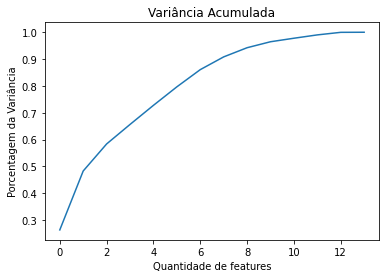

In [30]:
# drop irrelevant features
temp = df.drop(['id', 'Response', 'Gender', 'Vehicle_Age', 'Vehicle_Damage', 'Vintage', 'Policy_Sales_Channel'], axis=1).dropna()
temp = StandardScaler().fit_transform(temp)

# model description end fit
pca = PCA()

# fiting model
pca = pca.fit(temp)

# ploting cumulative sum
np.cumsum(pca.explained_variance_ratio_)
plt.title('Variância Acumulada')
plt.xlabel('Quantidade de features')
plt.ylabel('Porcentagem da Variância')
plt.plot(np.cumsum(pca.explained_variance_ratio_));

Os autovetores indicam que 6 dimensões parecem explicar 90% de toda variabilidade das features

## 5.3 Features Analysis

#### Response

###### Principais Insights:
1. Desbalanceada com 12% de eventos positivos
2. Correlação fraca com Vehicle_Damage e correlação fraca negativa com Previously_Insured

###### General Analysis

In [31]:
df['Response'].mean()

0.12256336113815208

In [32]:
df.corr()['Response'].sort_values(ascending=False)[1:]

Vehicle_Damage_                       0.354400
Policy_Sales_Channel_Response_Mean    0.263429
High_Age                              0.205981
Region_Code_Response_Mean             0.138095
Age                                   0.111147
Gender_                               0.052440
High_Annual_Premium                   0.038521
Annual_Premium                        0.022575
Region_Code                           0.010570
Driving_License                       0.010155
Log_Annual_Premium                    0.002707
Vintage                              -0.001050
id                                   -0.001368
Annual_Premium_Variated              -0.011783
Vehicle_Age_                         -0.104078
Policy_Sales_Channel                 -0.139042
Previously_Insured                   -0.341170
Name: Response, dtype: float64

Correlação fraca com Vehicle_Damage e correlação fraca negativa com Previously_Insured

#### Gender

###### Principais Insights:
1. Balanceada
2. Correlações muito fracas
3. Homens se interessam 30% mais no produto em relação às mulheres

###### General Analysis

In [33]:
df.corr()['Gender_'].sort_values(ascending=False)[1:]

Policy_Sales_Channel_Response_Mean    0.169888
High_Age                              0.159595
Age                                   0.146573
Vehicle_Damage_                       0.092273
Response                              0.052440
Region_Code_Response_Mean             0.044496
High_Annual_Premium                   0.023235
Annual_Premium                        0.003502
Region_Code                           0.000684
id                                   -0.001765
Vintage                              -0.002098
Log_Annual_Premium                   -0.014215
Driving_License                      -0.017720
Annual_Premium_Variated              -0.026550
Previously_Insured                   -0.082726
Policy_Sales_Channel                 -0.111565
Vehicle_Age_                         -0.113453
Name: Gender_, dtype: float64

Correlações muito fracas

In [34]:
le_gender.inverse_transform([0])

array(['Female'], dtype=object)

In [35]:
print(f'{round(df.loc[df["Gender_"]==0, "Response"].mean() *100, 2)}% das mulheres se interessam pelo produto.')
print(f'{round(df.loc[df["Gender_"]==1, "Response"].mean() *100, 2)}% dos homens se interessam pelo produto.')

10.39% das mulheres se interessam pelo produto.
13.84% dos homens se interessam pelo produto.


#### Age

###### Principais Insights:
1. Range de idade de 25 até 85 anos, aparentemente sem erros de input
2. Apresenta uma distribuição com uma certa semelhança com uma Poison, mas com uma segunda moda em um ponto próximo aos 45 anos.
3. Sem outliers
4. A média de idade entre os que não se interessam pelo produto é de 38 anos, e dos que se interessam é de 43 anos.
5. Pessoas com mais de 30 anos apresentam um interesse relativamente maior pelo produto.
6. Correlações moderadas negativas com Policy_Sales_Channel e Vehicle_Age, fraca negativa com Previously_Insured e fraca positiva com Vehicle_Damage

###### General Analysis

In [36]:
df.corr()['Age'].sort_values(ascending=False)[1:]

High_Age                              0.787797
Policy_Sales_Channel_Response_Mean    0.636832
Region_Code_Response_Mean             0.316050
Vehicle_Damage_                       0.268328
Gender_                               0.146573
High_Annual_Premium                   0.146376
Response                              0.111147
Annual_Premium                        0.067392
Region_Code                           0.041649
Vintage                              -0.000010
id                                   -0.000643
Log_Annual_Premium                   -0.010183
Annual_Premium_Variated              -0.064345
Driving_License                      -0.079660
Previously_Insured                   -0.255582
Vehicle_Age_                         -0.522770
Policy_Sales_Channel                 -0.577043
Name: Age, dtype: float64

Correlações moderadas negativas com Policy_Sales_Channel e Vehicle_Age, fraca negativa com Previously_Insured e fraca positiva com Vehicle_Damage

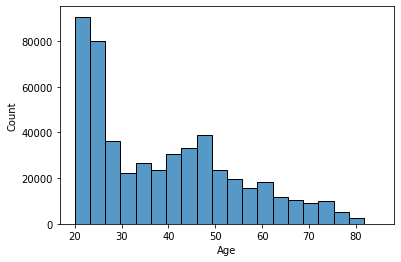

In [37]:
sns.histplot(df['Age'], bins=20);

Apresenta uma distribuição com uma certa semelhança com uma Poison, mas com uma segunda moda em um ponto próximo aos 45 anos.

In [38]:
analise_descritiva(df['Age'])

A média da Series é: 38.81
O valor máximo da Series é: 85
O valor mínimo da Series é: 20
O range é de: 65
O desvio padrão da Series é: 15.5
A curtose da Series é: -0.56
A skew da Series é: 0.67


In [39]:
índices, li, ls = buscar_outlier(df, 'Age')

In [40]:
df.loc[índices]

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,...,Response,Gender_,Vehicle_Damage_,Vehicle_Age_,Policy_Sales_Channel_Response_Mean,Region_Code_Response_Mean,High_Age,Log_Annual_Premium,Annual_Premium_Variated,High_Annual_Premium


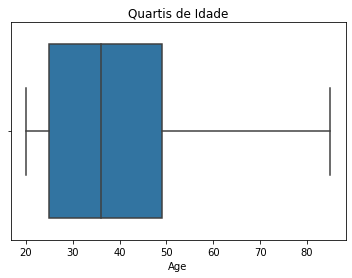

In [41]:
sns.boxplot(data=df, x='Age')
plt.title('Quartis de Idade');

sem outliers

In [42]:
print(f'A média de idade entre os que NÃO se interessam pelo produto: {round(df.loc[df["Response"]==0, "Age"].mean(), 2)}%')
print(f'A média de idade entre os que se interessam pelo produto: {round(df.loc[df["Response"]==1, "Age"].mean(), 2)}%')

A média de idade entre os que NÃO se interessam pelo produto: 38.18%
A média de idade entre os que se interessam pelo produto: 43.44%


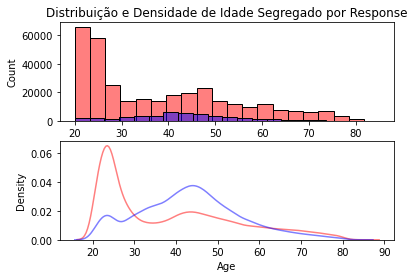

In [43]:
plt.subplot(2, 1, 1)
plt.title('Distribuição e Densidade de Idade Segregado por Response')
g = sns.histplot(df.loc[df['Response']==0, 'Age'], color='r', alpha=0.5, bins=20)
g = sns.histplot(df.loc[df['Response']==1, 'Age'], color='b', alpha=0.5, bins=20)
plt.subplot(2, 1, 2)
g = sns.kdeplot(df.loc[df['Response']==0, 'Age'], color='r', alpha=0.5)
g = sns.kdeplot(df.loc[df['Response']==1, 'Age'], color='b', alpha=0.5)

Pessoas mais velhas apresentam maior interesse no produto

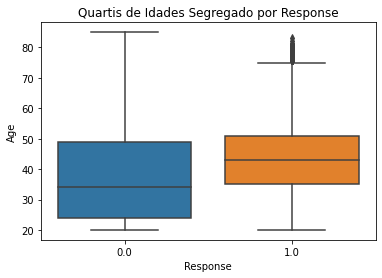

In [44]:
sns.boxplot(x='Response', y='Age', data=df)
plt.title('Quartis de Idades Segregado por Response');

Pessoas mais velhas apresentam interesse maior pelo produto

###### Teste de hipórese 4.2

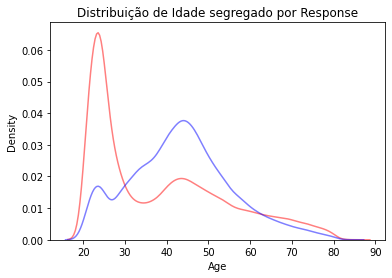

In [45]:
plt.title('Distribuição de Idade segregado por Response')
g = sns.kdeplot(df.loc[df['Response']==0, 'Age'], color='r', alpha=0.5)
g = sns.kdeplot(df.loc[df['Response']==1, 'Age'], color='b', alpha=0.5)

Adicionando aleatoriedade

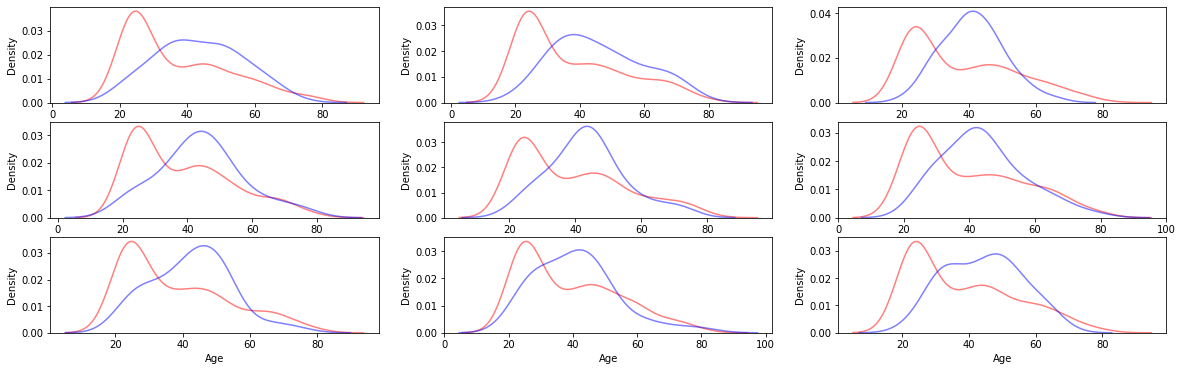

In [46]:
df.reset_index(drop=True, inplace=True)
plt.figure(figsize=(20, 6))
for i in range(1, 10):
    random_index = np.random.choice(df.index, 500, replace=False)
    temp = df.loc[random_index]
    plt.subplot(3, 3, i)
    g = sns.kdeplot(temp.loc[temp['Response']==0, 'Age'], color='r', alpha=0.5)
    g = sns.kdeplot(temp.loc[temp['Response']==1, 'Age'], color='b', alpha=0.5)

Por 9 vezes as linhas se cruzam em um ponto entre 28 e 37

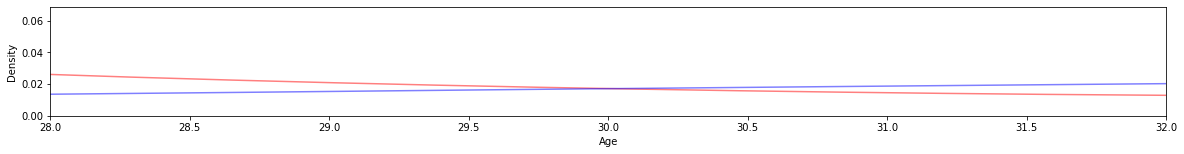

In [47]:
plt.figure(figsize=(20, 2))
plt.xlim(28, 32)
g = sns.kdeplot(df.loc[df['Response']==0, 'Age'], color='r', alpha=0.5)
g = sns.kdeplot(df.loc[df['Response']==1, 'Age'], color='b', alpha=0.5)

Feature **High_Response_Age** criada

In [48]:
print(f'A média de response entre os clientes com MENOS de 30 anos é: {round(df.loc[df["High_Age"]==0, "Response"].mean(), 2)}')
print(f'A média de response entre os clientes com MAIS de 30 anos é: {round(df.loc[df["High_Age"]==1, "Response"].mean(), 2)}')

A média de response entre os clientes com MENOS de 30 anos é: 0.04
A média de response entre os clientes com MAIS de 30 anos é: 0.18


A média de response dentre os clientes com mais de 30 anos é mais do que 50% superior em relação aos clientes com menos de 30 anos. Aceita e hipótese nula.

#### Driving_License

###### Principais Insights:
1. Correlações muito fracas
2. 99% dos clientes são habilitados
3. Habilitados apresentam 5% de interesse no produto, não habilitados apresentam 12% de interesse no produto.

###### General Analysis

In [49]:
df.corr()['Driving_License'].sort_values(ascending=False)[1:]

Policy_Sales_Channel                  0.042862
Vehicle_Age_                          0.030010
Previously_Insured                    0.014370
Response                              0.010155
id                                    0.001362
Region_Code                          -0.000202
Vintage                              -0.000850
Annual_Premium_Variated              -0.002716
Log_Annual_Premium                   -0.006955
Annual_Premium                       -0.012084
Vehicle_Damage_                      -0.015784
Region_Code_Response_Mean            -0.016148
High_Annual_Premium                  -0.016187
Gender_                              -0.017720
Policy_Sales_Channel_Response_Mean   -0.032776
High_Age                             -0.037265
Age                                  -0.079660
Name: Driving_License, dtype: float64

Correlações muito fracas

In [50]:
print(f'{round(df["Driving_License"].mean(), 3)}% dos clientes são habilitados')

0.998% dos clientes são habilitados


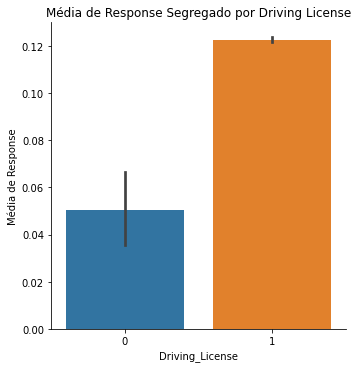

In [51]:
sns.catplot(x='Driving_License', y= 'Response', data=df, kind='bar')
plt.ylabel('Média de Response')
plt.title('Média de Response Segregado por Driving License');

In [52]:
print(f'Habilitados tem: {round(df.loc[df["Driving_License"]==0, "Response"].mean()*100, 2)}% de interesse no produto')
print(f'NÃO habilitados tem: {round(df.loc[df["Driving_License"]==1, "Response"].mean()*100, 2)}% de interesse no produto')

Habilitados tem: 5.05% de interesse no produto
NÃO habilitados tem: 12.27% de interesse no produto


#### Previously_Insured

###### Principais Insights:
1. 45% dos clientes já possuem seguro veicular
2. Clientes que já possuem seguro têm interesse quase zero pelo produto
3. Correlação muito forte negativa com Vehicle_Damage, fraca negativa com Response e Age, e fraca positiva com Policy_Sales_Channel

###### General Analysis

In [53]:
df.corr()['Previously_Insured'].sort_values(ascending=False)[1:]

Policy_Sales_Channel                  0.221334
Vehicle_Age_                          0.175548
Annual_Premium_Variated               0.088478
Log_Annual_Premium                    0.056660
Driving_License                       0.014370
Annual_Premium                        0.004776
id                                    0.002557
Vintage                               0.001664
Region_Code                          -0.023991
High_Annual_Premium                  -0.060264
Gender_                              -0.082726
Region_Code_Response_Mean            -0.179897
Age                                  -0.255582
High_Age                             -0.332756
Response                             -0.341170
Policy_Sales_Channel_Response_Mean   -0.419215
Vehicle_Damage_                      -0.823973
Name: Previously_Insured, dtype: float64

Correlação muito forte negativa com Vehicle_Damage, fraca negativa com Response e Age, e fraca positiva com Policy_Sales_Channel

In [54]:
df['Previously_Insured'].mean()

0.45866739086797886

45% dos clientes já sofreram danos veiculares

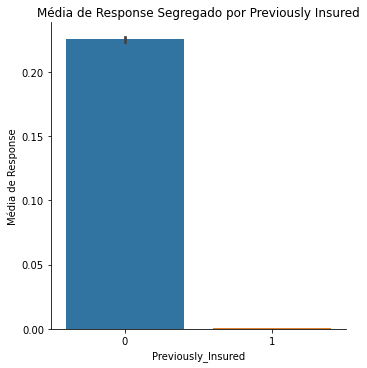

In [55]:
sns.catplot(x='Previously_Insured', y='Response', data=df, kind='bar')
plt.title('Média de Response Segregado por Previously Insured')
plt.ylabel('Média de Response');

In [56]:
df.loc[df['Previously_Insured']==1, 'Response'].mean()*100

0.09047804475799986

Clientes que possuem seguro veicular tem interesse quase zero no produto

#### Region_Code

###### Principais Insights:
1. 53 regiões
2. 28% dos clientes está contido na região 28. 50% dos dados estão contidos nas 5 regiões mais numerosas
3. A região 28 (mais importante) tem por volta de 18% de probabilidade de response, segunda melhor região, atrás apenas da região 38.
4. As regiões com probabilidade de response mais alto estão com por volta de 19%, as regiões com probabilidades mais baixas estã em por volta de 4%
5. Médias de response bastante distintas, com desvios padrões baixos

###### General Analysis:

In [57]:
df.corr()['Region_Code'].sort_values(ascending=False)[1:]

Region_Code_Response_Mean             0.076274
High_Age                              0.043653
Age                                   0.041649
Vehicle_Damage_                       0.027210
Policy_Sales_Channel_Response_Mean    0.026936
Response                              0.010570
Annual_Premium_Variated               0.003236
id                                    0.001325
Gender_                               0.000684
Driving_License                      -0.000202
Vintage                              -0.001568
Log_Annual_Premium                   -0.001691
Annual_Premium                       -0.012012
Previously_Insured                   -0.023991
High_Annual_Premium                  -0.026202
Vehicle_Age_                         -0.027622
Policy_Sales_Channel                 -0.042223
Name: Region_Code, dtype: float64

Correlações muito fracas

In [58]:
df['Region_Code'].nunique()

53

53 categorias

In [59]:
df['Region_Code'].value_counts(normalize=True).head(5)

28.0    0.279323
8.0     0.088360
46.0    0.051869
41.0    0.048018
15.0    0.034931
Name: Region_Code, dtype: float64

In [60]:
df['Region_Code'].value_counts(normalize=True).tail(5)

1.0     0.002682
44.0    0.002094
42.0    0.001549
52.0    0.000703
51.0    0.000533
Name: Region_Code, dtype: float64

In [61]:
df['Region_Code'].value_counts(normalize=True).head(5).sum()

0.5025012496408512

28% dos clientes está contido na região 28. 50% dos dados estão contidos nas 5 regiões mais densas.

In [62]:
df.groupby('Region_Code', as_index=False).agg({'Response':'mean'}).sort_values('Response', ascending=False).head(5)

,Region_Code,Response
38,38.0,0.192004
28,28.0,0.187163
19,19.0,0.162866
4,4.0,0.158245
23,23.0,0.153061


In [63]:
df.groupby('Region_Code', as_index=False).agg({'Response':'mean'}).sort_values('Response', ascending=False).tail(5)

,Region_Code,Response
22,22.0,0.063407
50,50.0,0.062677
10,10.0,0.060128
25,25.0,0.042749
44,44.0,0.040842


As regiões com probabilidade de response mais alto estão com por volta de 19%, as regiões com probabilidades mais baixas estã em por volta de 4%

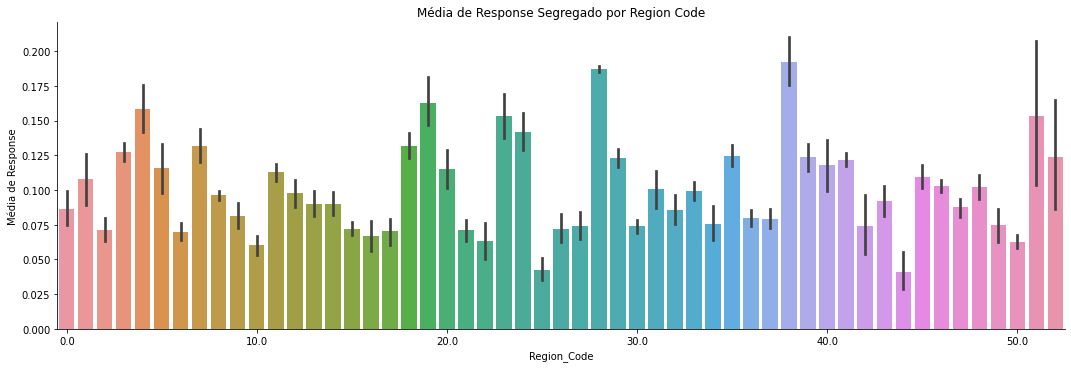

In [64]:
sns.catplot(x='Region_Code', y='Response', data=df, kind='bar', aspect=3)
plt.title('Média de Response Segregado por Region Code')
plt.xticks(range(0, int(df['Region_Code'].max()), 10))
plt.ylabel('Média de Response');

Médias de response bastante distintas, com desvios padrões baixos

#### Vehicle_Age

###### Principais insights:
1. Mais da metade dos clientes possuem carros com menos de 1 ano
2. Correlação moderada negativa com Age, fraca positiva com Policy_Sales_Channel
3. Médias de response bastante distintas

###### General Analysis

In [65]:
df.corr()['Vehicle_Age_'].sort_values(ascending=False)[1:]

Policy_Sales_Channel                  0.388868
Previously_Insured                    0.175548
Annual_Premium_Variated               0.089113
Log_Annual_Premium                    0.065386
Driving_License                       0.030010
Annual_Premium                        0.023545
Vintage                               0.001941
id                                   -0.000359
Region_Code                          -0.027622
High_Annual_Premium                  -0.031430
Response                             -0.104078
Gender_                              -0.113453
Vehicle_Damage_                      -0.174990
Region_Code_Response_Mean            -0.207726
Age                                  -0.522770
Policy_Sales_Channel_Response_Mean   -0.573390
High_Age                             -0.636472
Name: Vehicle_Age_, dtype: float64

Correlação moderada negativa com Age, fraca positiva com Policy_Sales_Channel

In [66]:
df['Vehicle_Age'].value_counts(normalize=True)

1-2 Year     0.525469
< 1 Year     0.432563
> 2 Years    0.041968
Name: Vehicle_Age, dtype: float64

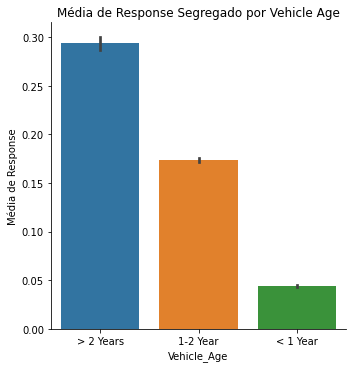

In [67]:
sns.catplot(x='Vehicle_Age', y='Response', data=df, kind='bar')
plt.ylabel('Média de Response')
plt.title('Média de Response Segregado por Vehicle Age');

Médias de response bastante distintas

#### Vehicle_Damage

###### Principais insights:
1. Balanceada
2. Correlação muito forte negativa com Previously_Insured, fraca negativa com Policy_Sales_Channel, fraca positiva com Response e Age
3. Clientes que já tiveram danos no seu veículo tem 24% de response, enquanto clientes que não tiveram danos têm por volta de 1%

###### General Analysis

In [68]:
df.corr()['Vehicle_Damage_'].sort_values(ascending=False)[1:]

Policy_Sales_Channel_Response_Mean    0.435397
Response                              0.354400
High_Age                              0.338477
Age                                   0.268328
Region_Code_Response_Mean             0.195931
Gender_                               0.092273
High_Annual_Premium                   0.069155
Region_Code                           0.027210
Annual_Premium                        0.009504
Vintage                              -0.001078
id                                   -0.002335
Driving_License                      -0.015784
Log_Annual_Premium                   -0.041054
Annual_Premium_Variated              -0.073731
Vehicle_Age_                         -0.174990
Policy_Sales_Channel                 -0.225856
Previously_Insured                   -0.823973
Name: Vehicle_Damage_, dtype: float64

Correlação muito forte negativa com Previously_Insured, fraca negativa com Policy_Sales_Channel, fraca positiva com Response e Age

In [69]:
df['Vehicle_Damage'].value_counts(normalize=True)

Yes    0.50428
No     0.49572
Name: Vehicle_Damage, dtype: float64

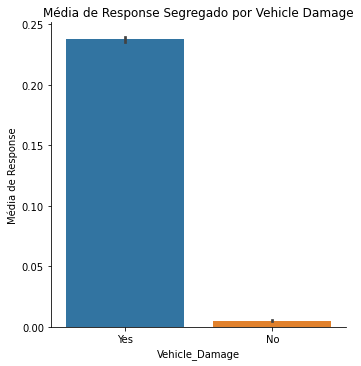

In [70]:
sns.catplot(x='Vehicle_Damage', y='Response', data=df, kind='bar')
plt.title('Média de Response Segregado por Vehicle Damage')
plt.ylabel('Média de Response');

In [71]:
print(f'Clientes que já tiveram danos tem: {round(df.loc[df["Vehicle_Damage"]=="Yes", "Response"].mean()*100, 2)}% de response')
print(f'Clientes que NÃO tiveram danos tem: {round(df.loc[df["Vehicle_Damage"]=="No", "Response"].mean()*100, 2)}% de response')

Clientes que já tiveram danos tem: 23.77% de response
Clientes que NÃO tiveram danos tem: 0.52% de response


Clientes que já tiveram danos no seu veículo tem 24% de response, enquanto clientes que não tiveram danos têm por volta de 1%

#### Annual_Premium

###### Principais insights:
1. 2799 em Annual_Premmium, não aparentam ser por conta de erros de input
2. Há dois grupos de clientes, um com valores fixos em 2630 dollares, e outro com valores contínuos e superiores, não há diferença significativa de média de interesse no produto entre os grupos
3. Aparentemente acima do terceiro quartil da distribuição há um interesse maior no produto

###### General Analysis

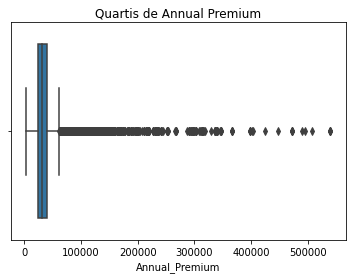

In [72]:
sns.boxplot(x='Annual_Premium', data=df)
plt.title('Quartis de Annual Premium');

Muitos outliers

In [73]:
índices, li, ls = buscar_outlier(df, 'Annual_Premium')

In [74]:
print(f'Há {len(índices)} outliers no total')

Há 2799 outliers no total


In [75]:
df.corr()['Annual_Premium'].sort_values(ascending=False)[1:]

Log_Annual_Premium                    0.877883
Annual_Premium_Variated               0.737574
High_Annual_Premium                   0.637120
Region_Code_Response_Mean             0.252035
Age                                   0.067392
Vehicle_Age_                          0.023545
Response                              0.022575
High_Age                              0.018329
Vehicle_Damage_                       0.009504
Previously_Insured                    0.004776
Gender_                               0.003502
id                                    0.001042
Policy_Sales_Channel_Response_Mean   -0.000101
Vintage                              -0.000855
Region_Code                          -0.012012
Driving_License                      -0.012084
Policy_Sales_Channel                 -0.114035
Name: Annual_Premium, dtype: float64

Correlações muito fracas

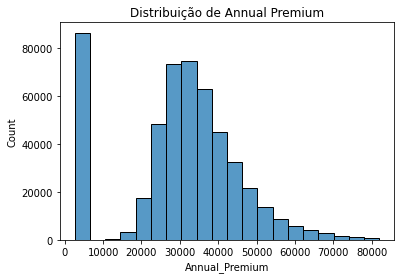

In [76]:
sns.histplot(df.drop(índices)['Annual_Premium'], bins=20)
plt.title('Distribuição de Annual Premium');

In [77]:
df['Annual_Premium'].value_counts(normalize=True).head(5)

2630.0     0.170203
69856.0    0.000364
45179.0    0.000112
38452.0    0.000110
39008.0    0.000108
Name: Annual_Premium, dtype: float64

17% dos clientes estão contidos em um valor discreto de 2630 dollares. Um estudo separadamente para este grupo pode ser interessante.

In [78]:
print(f'A média de interesse no produto do grupo de clientes com valor FIXO de seguro: {round(df.loc[df["Annual_Premium"]==2630, "Response"].mean()*100, 2)}%')
print(f'A média de interesse no produto do grupo de clientes com valor VARIÁVEL SUPERIOR de seguro: {round(df.loc[df["Annual_Premium"]!=2630, "Response"].mean()*100, 2)}%')

A média de interesse no produto do grupo de clientes com valor FIXO de seguro: 13.11%
A média de interesse no produto do grupo de clientes com valor VARIÁVEL SUPERIOR de seguro: 12.08%


O interesse no produto não é significativamente diferente entre os dois grupos de clientes

**Nicho Variável**

Para uma melhor visualização, os dados serão filtrados provisioriamente até 100000 dollares

In [79]:
temp = df.loc[(df['Annual_Premium']>2630)&(df['Annual_Premium']<100000)]

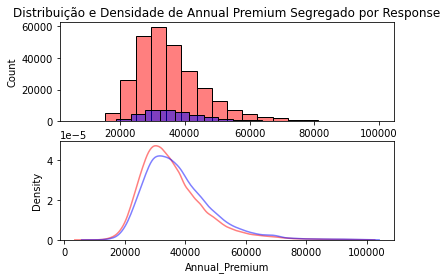

In [80]:
plt.subplot(2, 1, 1)
plt.title('Distribuição e Densidade de Annual Premium Segregado por Response')
g = sns.histplot(temp.loc[temp['Response']==0, 'Annual_Premium'], color='r', alpha=0.5, bins=20)
g = sns.histplot(temp.loc[temp['Response']==1, 'Annual_Premium'], color='b', alpha=0.5, bins=20)
plt.subplot(2, 1, 2)
g = sns.kdeplot(temp.loc[temp['Response']==0, 'Annual_Premium'], color='r', alpha=0.5)
g = sns.kdeplot(temp.loc[temp['Response']==1, 'Annual_Premium'], color='b', alpha=0.5)

Aparentemente acima do terceiro quartil da distribuição há um interesse maior no produto

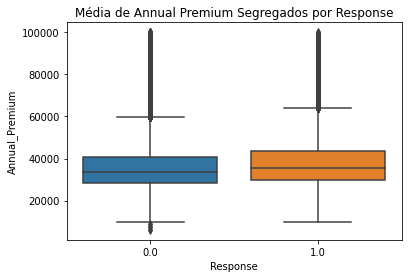

In [81]:
plt.title('Média de Annual Premium Segregados por Response')
sns.boxplot(x='Response', y='Annual_Premium', data=temp);

Sem diferença significativa

**Nicho Fixo**

In [82]:
temp = df[df['Annual_Premium']==2630]

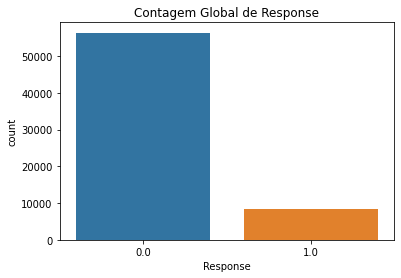

In [83]:
plt.title('Contagem Global de Response')
sns.countplot(x='Response', data=temp);

###### Teste de hipótese 4.3

Feature **High_Annual_Premium** criada

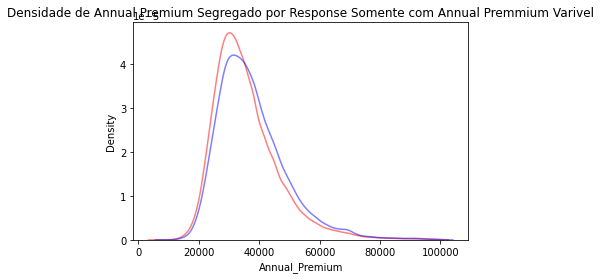

In [84]:
temp = df[df['Annual_Premium']<100000]
plt.title('Densidade de Annual Premium Segregado por Response Somente com Annual Premmium Varivel')
g = sns.kdeplot(temp.loc[(temp['Annual_Premium_Variated']==1)&(temp['Response']==0), 'Annual_Premium'], color='r', alpha=0.5)
g = sns.kdeplot(temp.loc[(temp['Annual_Premium_Variated']==1)&(temp['Response']==1), 'Annual_Premium'], color='b', alpha=0.5);

Adicionando aleatoriedade

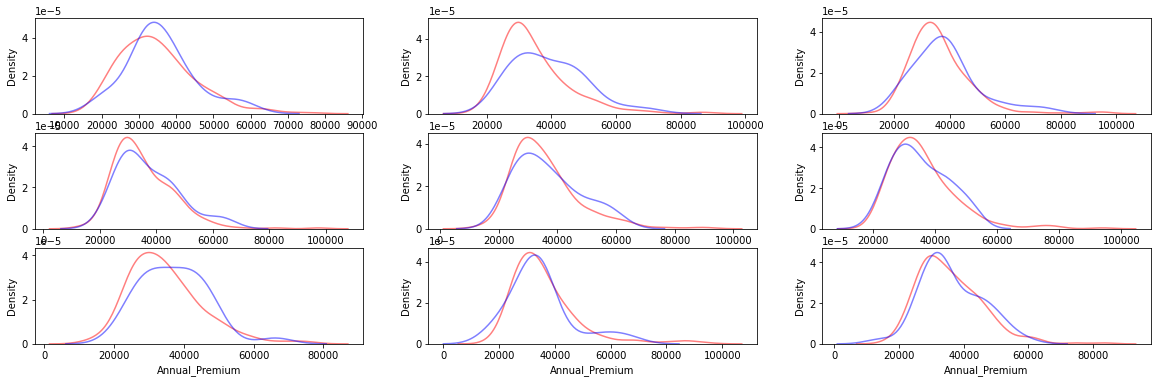

In [85]:
temp = df[df['Annual_Premium']<100000]
plt.figure(figsize=(20, 6))
for i in range(1, 10):
    plt.subplot(3, 3, i)
    índices_aleatórios = np.random.choice(temp.index, 500, replace=False)
    temp1 = temp.loc[índices_aleatórios]
    g = sns.kdeplot(temp1.loc[(temp1['Annual_Premium_Variated']==1)&(temp1['Response']==0), 'Annual_Premium'], color='r', alpha=0.5)
    g = sns.kdeplot(temp1.loc[(temp1['Annual_Premium_Variated']==1)&(temp1['Response']==1), 'Annual_Premium'], color='b', alpha=0.5);

Em um dado acima do terceiro quartil, parece haver maior interesse no produto, porém adicionando-se aleatoriedade, tal fato não demonstra ser estável, sendo comprovado em algumas amostras e em outras não.

In [86]:
print(f'A média de Response entre os clientes que fazem parte dos High_Annual_Premium: {round(df.loc[df["High_Annual_Premium"]==1, "Response"].mean(), 2)}')
print(f'A média de Response entre os clientes que NÃO fazem parte dos High_Annual_Premium: {round(df.loc[df["High_Annual_Premium"]==0, "Response"].mean(), 2)}')

A média de Response entre os clientes que fazem parte dos High_Annual_Premium: 0.15
A média de Response entre os clientes que NÃO fazem parte dos High_Annual_Premium: 0.12


A diferença entre as médias de Response foi de por volta de 20% entre os grupos, portanto, rejeita a hipótese nula.

#### Policy_Sales_Channel

###### Main insights:
1. Há 157 Policy_Sales_Channel e aproximadamente um terço das amostras está contido no canal 152
2. 5 categorias contém 84.19% do total de clientes
3. Correlação moderada negativa com Age, correlação fraca negativa com Vehicle_Damage, correlação fraca positiva com Vehicle_Age e Previously_Insured
4. Médias de response por canais de Policy_Sales_Channel bastante distintas
5. Os canais mais utilizados apresentam médias de response bastante diferentes da média global, os canal 152 é o mais utilizado e apresenta 2% de interesse no produto, o canal 155 apresenta 2%, já os canais 26, 124 e 156 apresentam por volta de 20% de interesse no produto

###### General Analysis

In [87]:
df.corr()['Policy_Sales_Channel'].sort_values(ascending=False)[1:]

Vehicle_Age_                          0.388868
Previously_Insured                    0.221334
Driving_License                       0.042862
Vintage                              -0.000814
id                                   -0.002812
Annual_Premium_Variated              -0.015966
Region_Code                          -0.042223
Log_Annual_Premium                   -0.061878
Gender_                              -0.111565
Annual_Premium                       -0.114035
Response                             -0.139042
High_Annual_Premium                  -0.147901
Vehicle_Damage_                      -0.225856
Region_Code_Response_Mean            -0.287069
Policy_Sales_Channel_Response_Mean   -0.527793
High_Age                             -0.552597
Age                                  -0.577043
Name: Policy_Sales_Channel, dtype: float64

Correlação moderada negativa com Age, correlação fraca negativa com Vehicle_Damage, correlação fraca positiva com Vehicle_Age e Previously_Insured

In [88]:
df['Policy_Sales_Channel'].value_counts(normalize=True).head(5)

152.0    0.353290
26.0     0.209770
124.0    0.193446
160.0    0.057247
156.0    0.028167
Name: Policy_Sales_Channel, dtype: float64

In [89]:
canais_mais_utilizados = df['Policy_Sales_Channel'].value_counts(normalize=True).head(5).index

In [90]:
print(f'5 categorias contém {round(df["Policy_Sales_Channel"].value_counts(normalize=True).head(5).sum()*100, 2)}% do total de clientes')

5 categorias contém 84.19% do total de clientes


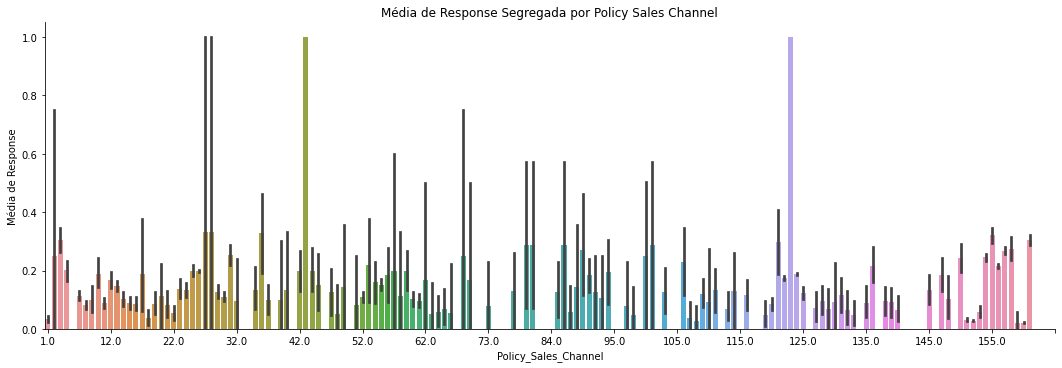

In [91]:
sns.catplot(x='Policy_Sales_Channel', y='Response', data=df, kind='bar', aspect=3)
plt.xticks(range(0, int(df['Policy_Sales_Channel'].max()), 10))
plt.title('Média de Response Segregada por Policy Sales Channel')
plt.ylabel('Média de Response');

Médias de response por canais de Policy_Sales_Channel bastante distintas

In [92]:
temp = df.groupby('Policy_Sales_Channel', as_index=False).agg({'Response':'count'})
temp.rename(columns={'Response':'Response_Count'}, inplace=True)

temp2 = df.groupby('Policy_Sales_Channel', as_index=False).agg({'Response':'mean'})
temp2.rename(columns={'Response':'Response_Mean'}, inplace=True)

temp3 = temp.merge(temp2, how='left', on='Policy_Sales_Channel')
temp3.sort_values('Response_Count', ascending=False).head(5)

,Policy_Sales_Channel,Response_Count,Response_Mean
147,152.0,134784,0.028624
24,26.0,79700,0.199385
119,124.0,73995,0.189148
155,160.0,21779,0.021810
151,156.0,10661,0.215458


Os canais mais utilizados apresentam médias de response bastante diferentes da média global, os canal 152 é o mais utilizado e apresenta 2% de interesse no produto, o canal 155 apresenta 2%, já os canais 26, 124 e 156 apresentam por volta de 20% de interesse no produto

In [93]:
del(temp, temp2, temp3)

#### Vintage

###### Main insights:
1. Feature categórica, há 290 categorias em Vintage

###### General Analysis

In [94]:
df.corr()['Vintage'].sort_values(ascending=False)[1:]

Vehicle_Age_                          0.001941
Previously_Insured                    0.001664
Region_Code_Response_Mean             0.000319
Age                                  -0.000010
High_Annual_Premium                  -0.000177
id                                   -0.000391
Policy_Sales_Channel                 -0.000814
Driving_License                      -0.000850
Annual_Premium                       -0.000855
Response                             -0.001050
Vehicle_Damage_                      -0.001078
High_Age                             -0.001295
Policy_Sales_Channel_Response_Mean   -0.001333
Region_Code                          -0.001568
Log_Annual_Premium                   -0.001926
Gender_                              -0.002098
Annual_Premium_Variated              -0.002495
Name: Vintage, dtype: float64

Correlações muito fracas

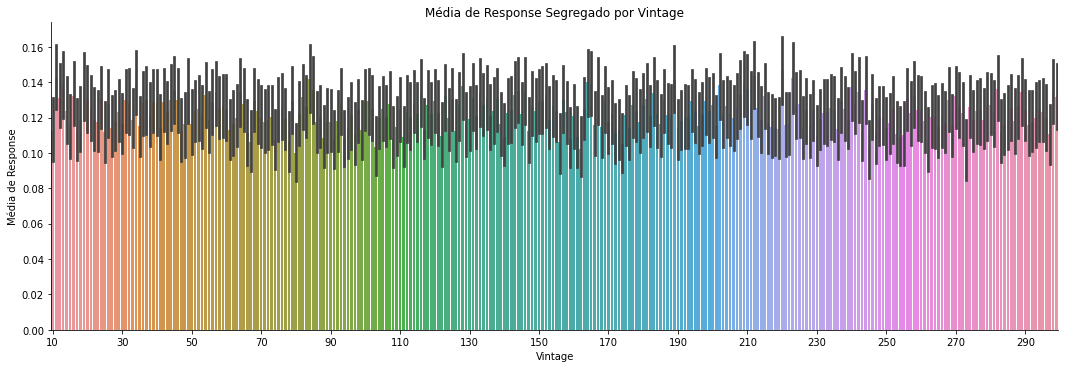

In [95]:
sns.catplot(x='Vintage', y='Response', data=df, kind='bar', aspect=3)
plt.title('Média de Response Segregado por Vintage')
plt.ylabel('Média de Response')
plt.xticks(range(0, df['Vintage'].max(), 20));

Muito ruidoso, os desvios padrões colocam tudo no mesmo nível.

## 5.4 Removing expendable features

In [96]:
df.drop(['High_Annual_Premium', 'Annual_Premium_Variated'], axis=1, inplace=True)

Features **High_Annual_Premium e Annual_Premium_Variated** foram testadas pelo ml_modeling, não contribuíram com o mocelo, portanto serão removidas.

## 5.5 Principais Features e Importâncias

### 5.5.1 Tree Plot

Este campo pode ser rodado apenas após o processamento do notebook "data_preparation"

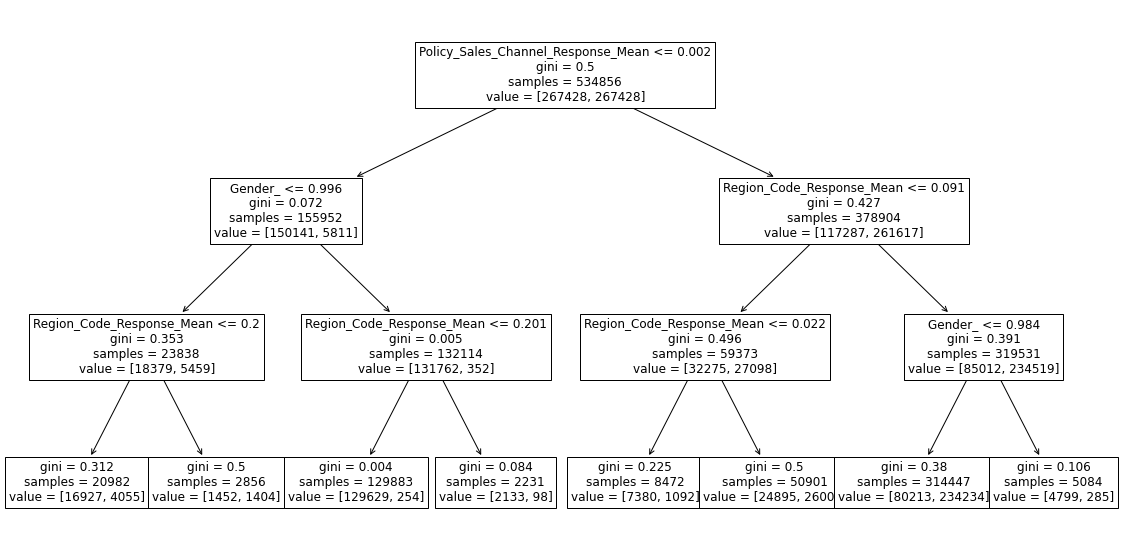

In [97]:
# importing prepared data
X = pickle.load(open('D:\\My Drive\\Pessoal\\Projetos\\insurance_sales_predict\\insurance_sales_predict\\exportings\\X_imb_to_modeling.pkl', 'rb'))
y = pickle.load(open('D:\\My Drive\\Pessoal\\Projetos\\insurance_sales_predict\\insurance_sales_predict\\exportings\\y_to_modeling.pkl', 'rb'))
model_columns = pickle.load(open('D:\\My Drive\\Pessoal\\Projetos\\insurance_sales_predict\\insurance_sales_predict\\exportings\\model_columns.pkl', 'rb'))
scaler = pickle.load(open('D:\\My Drive\\Pessoal\\Projetos\\insurance_sales_predict\\webapp\\scaler_standard_scaler.pkl', 'rb'))

# catching interesting arrays
X_smote = X[0]
y_smote = y[0]

# inversing scaler transformation 
X_smote = np.insert(X_smote, 1, np.zeros(534856), axis=1)
X_smote = scaler.inverse_transform(X_smote)
np.delete(X_smote, 1, 1) # feature selection

# model definition
tree_model = DecisionTreeClassifier(max_depth=3, random_state=101)
tree_model.fit(X_smote, y_smote)

# ploting tree
pl.figure(figsize=(20, 10))
plot_tree(tree_model, fontsize=12, feature_names=model_columns);

### 5.5.2 Importances

In [98]:
ranking = pickle.load(open('D:\\My Drive\\Pessoal\\Projetos\\insurance_sales_predict\\insurance_sales_predict\\exportings\\ranking_feature_selection.pkl', 'rb'))

ranking

,correlations,rfe_xgb,importance_rf,importance_xgb,boruta
Age,0.111147,1,0.090311,0.006751,1
Driving_License,0.010155,7,0.000000,0.000000,2
Previously_Insured,0.341170,6,0.385390,0.179623,1
Gender_,0.052440,5,0.001478,0.000637,1
Vehicle_Damage_,0.354400,3,0.326500,0.771877,1
Policy_Sales_Channel_Response_Mean,0.263429,1,0.114693,0.019289,1
Region_Code_Response_Mean,0.138095,1,0.015241,0.001816,1
High_Response_Age,0.205981,4,0.019355,0.017652,1
Log_Annual_Premium,0.002707,2,0.002555,0.000139,1
Vehicle_Age_1,0.209878,1,0.041700,0.000041,1


1. As colunas "correlations", "importance_rf" e "importance_xgb" são quantitativas e estão na mesma escala
2. A coluna "rfe_xgb" é tipo tipo ranking, quanto menor o número melhor a colocação
3. A coluna "boruta" é binária, 1 significa uma feature relevante e 2 uma feature a ser dispensada

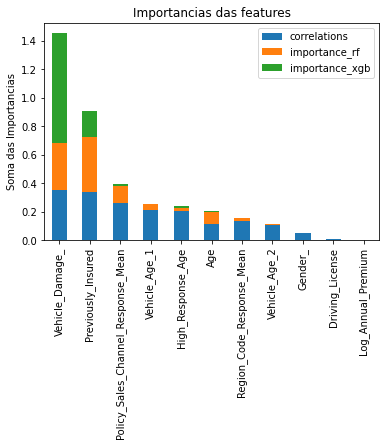

In [99]:
ranking_1 = ranking[['correlations', 'importance_rf', 'importance_xgb']].copy()
ranking_1['total'] = np.sum(ranking_1, axis=1)

ranking_1.sort_values('total', ascending=False, inplace=True)

ranking_1.drop('total', axis=1).plot(kind='bar', stacked=True)
plt.title('Importancias das features')
plt.ylabel('Soma das Importancias');

# 6.0 Exportings

###### 6.1 Dataframe

In [100]:
pickle.dump(df, open('D:\\My Drive\\Pessoal\\Projetos\\insurance_sales_predict\\insurance_sales_predict\\exportings\\df_to_data_preparation.pkl', 'wb'))
print('Criado df processado para seguir para preparação de dados e ML')

Criado df processado para seguir para preparação de dados e ML


###### 6.2 Encodings

In [101]:
pickle.dump(le_gender, open('D:\\My Drive\\Pessoal\\Projetos\\insurance_sales_predict\\webapp\\le_gender.pkl', 'wb'))
pickle.dump(le_vehicle_damage, open('D:\\My Drive\\Pessoal\\Projetos\\insurance_sales_predict\\webapp\\le_vehicle_damage.pkl', 'wb'))
pickle.dump(le_vehicle_age, open('D:\\My Drive\\Pessoal\\Projetos\\insurance_sales_predict\\webapp\\le_vehicle_age.pkl', 'wb'))

###### 6.3 Features

In [102]:
# pickle policy_sales_channel map
pickle.dump(map_policy_sales_channel_response_mean, open('D:\\My Drive\\Pessoal\\Projetos\\insurance_sales_predict\webapp\\map_policy_sales_channel_response_mean.pkl', 'wb'))

# pickle region_code map
pickle.dump(map_region_code_response_mean, open('D:\\My Drive\\Pessoal\\Projetos\\insurance_sales_predict\\webapp\\map_region_code_response_mean.pkl', 'wb'))

# Time

In [103]:
print(f'O tempo de processamento do projeto foi de: {int(round(time.time()-time_agora, 2)/60)} minutos')

O tempo de processamento do projeto foi de: 1 minutos
